# Data Cleaning and Augmentation

The Topic Modeling part is adapted from https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/topic_modeling_Gensim.ipynb

## Data Cleaning

As we discussed in the slides, we will start with data preprocessing which is sometimes also call data cleaning. Depending on the type of data you have, you might have different workflows for data cleaning. But we will assume that at this step our data is available in a rectangular format which can loaded using dataframes. And we will primarily clean text data. What is meant by data cleaning?

- remove social media specific language
- remove stopwords
- tokenization

One can also include dropping or imputing missing values a part of data cleaning but we will not cover that here.

In [ ]:
import pandas as pd

In [5]:
elections_df = pd.read_csv("elections.csv") # we will use the same dataset we had shown in the previous notebook
elections_df.head()

,Post ID,Title,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Subreddit
0,jdr9ej,Holy Hell - FBI agent investigating CHILD PORN...,https://pittsburgh.forums.rivals.com/threads/h...,TrumpFan-45,1,2020-10-19 02:00:46,8,/r/donaldtrump/comments/jdr9ej/holy_hell_fbi_a...,:snoo_scream: PANIC IN D.C. :snoo_surprised:,donaldtrump
1,jdracy,Biden Surrogate Arrested on Child Pornography ...,https://m.theepochtimes.com/biden-surrogate-ar...,TrumpFan-45,1,2020-10-19 02:02:26,3,/r/donaldtrump/comments/jdracy/biden_surrogate...,:snoo_scream: PANIC IN D.C. :snoo_surprised:,donaldtrump
2,jdrdat,Trump dancing with me while I lip sync to Upri...,https://v.redd.it/af5a6nz90yt51,leandroman,1,2020-10-19 02:07:32,2,/r/donaldtrump/comments/jdrdat/trump_dancing_w...,NaN,donaldtrump
3,jdre50,He’s probably as high as ammo prices rn,https://i.redd.it/d4fiwz661yt51.jpg,limacharlie1776,1,2020-10-19 02:09:05,2,/r/donaldtrump/comments/jdre50/hes_probably_as...,NaN,donaldtrump
4,jdrens,Just saw for myself a behind the scenes look a...,https://i.redd.it/oshjah3c1yt51.png,TrumpFan-45,1,2020-10-19 02:10:00,28,/r/donaldtrump/comments/jdrens/just_saw_for_my...,:snoo_scream: PANIC IN D.C. :snoo_surprised:,donaldtrump


In [6]:
import spacy
# !python -m spacy download en
# spacy.load('en')
from spacy.lang.en import English
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

Let's try an example of tokenization with the function we just defined.

In [7]:
text_example = elections_df['Title'][0]
text_example

"Holy Hell - FBI agent investigating CHILD PORN has subpoenaed Hunter Biden's laptop"

In [8]:
tokenize(text_example)

['holy',
 'hell',
 '-',
 'fbi',
 'agent',
 'investigating',
 'child',
 'porn',
 'has',
 'subpoenaed',
 'hunter',
 'biden',
 "'s",
 'laptop']

In [9]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [13]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [14]:
for w in ['dogs', 'ran', 'discouraged']:
    print(w, get_lemma(w), get_lemma2(w))

dogs dog dog
ran run ran
discouraged discourage discouraged


In [15]:
for word in tokenize(text_example):
    print(word, get_lemma(word))

holy holy
hell hell
- -
fbi fbi
agent agent
investigating investigating
child child
porn porn
has ha
subpoenaed subpoena
hunter hunter
biden biden
's 's
laptop laptop


In [16]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
def get_tokens(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [18]:
get_tokens(text_example)

['agent', 'investigating', 'child', 'subpoena', 'hunter', 'biden', 'laptop']

choice of package can affect the analysis: something to keep in mind when reading and writing the papers

- where small issues and discrepencies can happen
- sentiment analysis has many intemediate steps that can affect the final estimate

## Data Augmentation

Now that we have collected, stored and cleaned data, we can move on to enriching it. We will cover the following data enrichment processes:
    - sentiment analysis
    - topic modeling
    - OPTIONAL:  Toxicity API

### Sentiment Analysis

There are several options for sentiment analysis. Today we will use VADER sentiment: https://github.com/cjhutto/vaderSentiment which stands for Valence Aware Dictionary and sEntiment Reasoner. It is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 

In [19]:
import nltk # VADER is a part of the popular NLP toolkit called nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [20]:
elections_df['Sentiment'] = [sid.polarity_scores(i) for i in elections_df['Title']]
elections_df['Sentiment'] = [sid.polarity_scores(i)['compound'] for i in elections_df['Title']]
elections_df.head()

,Post ID,Title,Url,Author,Score,Publish Date,Total No. of Comments,Permalink,Flair,Subreddit,Sentiment
0,jdr9ej,Holy Hell - FBI agent investigating CHILD PORN...,https://pittsburgh.forums.rivals.com/threads/h...,TrumpFan-45,1,2020-10-19 02:00:46,8,/r/donaldtrump/comments/jdr9ej/holy_hell_fbi_a...,:snoo_scream: PANIC IN D.C. :snoo_surprised:,donaldtrump,-0.6808
1,jdracy,Biden Surrogate Arrested on Child Pornography ...,https://m.theepochtimes.com/biden-surrogate-ar...,TrumpFan-45,1,2020-10-19 02:02:26,3,/r/donaldtrump/comments/jdracy/biden_surrogate...,:snoo_scream: PANIC IN D.C. :snoo_surprised:,donaldtrump,-0.4767
2,jdrdat,Trump dancing with me while I lip sync to Upri...,https://v.redd.it/af5a6nz90yt51,leandroman,1,2020-10-19 02:07:32,2,/r/donaldtrump/comments/jdrdat/trump_dancing_w...,NaN,donaldtrump,0.0000
3,jdre50,He’s probably as high as ammo prices rn,https://i.redd.it/d4fiwz661yt51.jpg,limacharlie1776,1,2020-10-19 02:09:05,2,/r/donaldtrump/comments/jdre50/hes_probably_as...,NaN,donaldtrump,0.0000
4,jdrens,Just saw for myself a behind the scenes look a...,https://i.redd.it/oshjah3c1yt51.png,TrumpFan-45,1,2020-10-19 02:10:00,28,/r/donaldtrump/comments/jdrens/just_saw_for_my...,:snoo_scream: PANIC IN D.C. :snoo_surprised:,donaldtrump,-0.1027


In [21]:
import matplotlib.pyplot as plt

In [22]:
elections_df.Subreddit.unique()

array(['donaldtrump', 'politics', 'JoeBiden'], dtype=object)

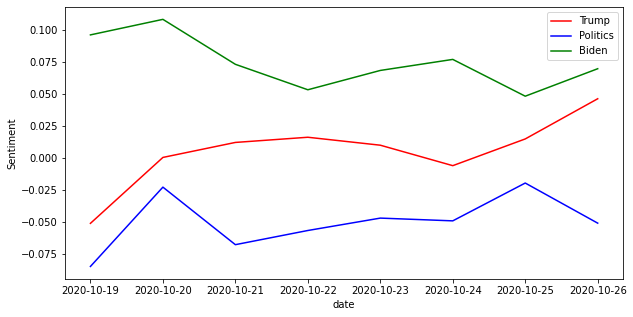

In [23]:
ax, fig = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 5))
elections_df['date'] = pd.to_datetime(elections_df['Publish Date']).dt.floor('d')
m1 = elections_df[elections_df['Subreddit'] == "donaldtrump"].groupby(elections_df.date).Sentiment.mean().reset_index()
m2 = elections_df[elections_df['Subreddit'] == "politics"].groupby(elections_df.date).Sentiment.mean().reset_index()
m3 = elections_df[elections_df['Subreddit'] == "JoeBiden"].groupby(elections_df.date).Sentiment.mean().reset_index()

import seaborn as sns

ax = sns.lineplot(data = m1, x = 'date', y = 'Sentiment', color = "red", label = 'Trump')
ax = sns.lineplot(data = m2, x = 'date', y = 'Sentiment', color = "blue", label = 'Politics')
ax = sns.lineplot(data = m3, x = 'date', y = 'Sentiment', color = "green", label = 'Biden')


## Topic Modeling

The last demo for data enriching is topic modeling where we use the LDA algorithm to find latent topics in our data.

In [24]:
import random
text_data = []
for line in elections_df['Title']:
    tokens = get_tokens(line)
    if random.random() > .99:
        print(line)
        print(tokens)
        text_data.append(tokens)

How the average person sees Jake Tapper interview
['average', 'person', 'tapper', 'interview']
Wrote a new blog post to troll all my liberal friends on Facebook check it out.
['write', 'troll', 'liberal', 'friend', 'facebook', 'check']
Remember when impeachment was about daring to look for fire where there was smoke? Now there is proof of fire and nobody cares
['remember', 'impeachment', 'daring', 'smoke', 'proof', 'nobody', 'care']
WATCH: The Media Has Waged a Four-Year War Against Trump
['watch', 'medium', 'wage', 'trump']
I'm making Halloween great again.
['making', 'halloween', 'great']
Mark Meadows: Biden Family Involved in Hundreds of Millions of Dollars in Money Laundering Schemes
['meadow', 'biden', 'family', 'involve', 'hundred', 'million', 'dollar', 'money', 'laundering', 'scheme']
The Trump Administration Is Committed to Combating Human Trafficking and Protecting The Innocent
['trump', 'administration', 'commit', 'combat', 'human', 'traffic', 'protect', 'innocent']
Tried to 

In [25]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)

In [26]:
corpus = [dictionary.doc2bow(text) for text in text_data]

In [27]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [28]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')

In [29]:
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)


(0, '0.032*"trump" + 0.015*"election" + 0.012*"group" + 0.009*"supporter"')
(1, '0.055*"trump" + 0.052*"biden" + 0.016*"voter" + 0.013*"early"')
(2, '0.031*"trump" + 0.022*"biden" + 0.018*"democrat" + 0.011*"covid-19"')
(3, '0.037*"biden" + 0.029*"trump" + 0.017*"election" + 0.013*"obama"')
(4, '0.030*"trump" + 0.023*"biden" + 0.012*"would" + 0.008*"american"')


In [30]:
new_doc = 'Trump is corrupt'
new_doc = get_tokens(new_doc)
new_doc_bow = dictionary.doc2bow(new_doc)
print(new_doc_bow)
print(ldamodel.get_document_topics(new_doc_bow))

[(18, 1)]
[(0, 0.102266766), (1, 0.59172785), (2, 0.102112584), (3, 0.101891965), (4, 0.10200089)]


In [31]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.030*"biden" + 0.028*"trump" + 0.011*"american" + 0.011*"democrat"')
(1, '0.068*"trump" + 0.035*"biden" + 0.011*"election" + 0.009*"donald"')
(2, '0.013*"election" + 0.012*"biden" + 0.012*"covid-19" + 0.008*"barrett"')


In [32]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.054*"trump" + 0.027*"biden" + 0.021*"donald" + 0.014*"election"')
(1, '0.034*"trump" + 0.021*"attack" + 0.021*"biden" + 0.014*"election"')
(2, '0.017*"russia" + 0.017*"polls" + 0.017*"member" + 0.017*"thought"')
(3, '0.035*"trump" + 0.018*"early" + 0.018*"street" + 0.012*"biden"')
(4, '0.048*"biden" + 0.042*"trump" + 0.019*"american" + 0.013*"today"')
(5, '0.049*"biden" + 0.043*"trump" + 0.013*"election" + 0.013*"final"')
(6, '0.028*"trump" + 0.021*"video" + 0.014*"endorsement" + 0.014*"issue"')
(7, '0.031*"democrat" + 0.023*"covid-19" + 0.023*"vaccine" + 0.022*"senate"')
(8, '0.051*"trump" + 0.036*"biden" + 0.021*"offense" + 0.014*"would"')
(9, '0.049*"biden" + 0.034*"trump" + 0.015*"information" + 0.015*"election"')


There are several other topic modeling techniques:

- LSA
- word-embedding based
- hierarchical techniques

## Visualizing topics

In [33]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

In [35]:
!python3 -m pip install -U pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 24.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=886e60dc4ee2ce169be6616c904aef2721fae28f25174910f9bb9274ee45bc9c
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=ca84870ef3b8d9b324f3b163bdfd62063fb0a73752bf8cd755377c9cb5b00208
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [39]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
lda_display = gensimvis.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [41]:
lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
lda_display3 = gensimvis.prepare(lda3, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display3)

/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.8/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas

### Toxicity

Toxicity: https://github.com/conversationai/perspectiveapi/tree/master/1-get-started

This is a popular library that can be used in an 'off-the-shelf' manner to annotate toxic and related concepts in text. In this demo, we will see how to use the API with Python. Like the Twitter API, getting the Toxicity API approved can take some time. So, instead we will demonstrate how it can be used. 

In [ ]:
from perspective import parse_summary_scores, get_toxicity_scores

ModuleNotFoundError: ignored

In [ ]:
with open("perspective.csv") as f:
        key = f.read().strip()

comments = [u'you ugly duck', u'the sun shines today', u'steven wilson is the god of prog']
results = list(zip(comments, map(parse_summary_scores, get_toxicity_scores(comments, key, requested_attributes = {"TOXICITY":{}}))))
for result in results:
    print(result)

FileNotFoundError: ignored

In [ ]:
# How to add toxicity scores to your data. This will not run on your system since you do not have teh API key

# comments = elections_df['Title']
# ids = elections_df['Post ID']
# results = list(zip(ids, comments, map(parse_summary_scores, get_toxicity_scores(comments, key, requested_attributes = {"TOXICITY":{}}))))

In [ ]:
# elections_df['TOXICITY'] = [i[2]['TOXICITY'] for i in results]
# elections_df.head()

In [ ]:
# elections_df.to_csv("elections_toxicity.csv", encoding = 'utf-8', index = False)

We have also enriched the elections dataset with toxicity values in a seperate csv file called "elections_toxicity.csv". You can load that csv with pandas and play around with the toxicity scores.

In [ ]:
elections_toxicity = pd.read_csv("elections_toxicity.csv", encoding = 'utf-8')
elections_toxicity.head()

Try it yourself: You can try out the following:

- One topic model each for each subreddit
- Enriching the posts in the election dataset with Named Entities (Hint: try using NLTK)